In [371]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.stats import norm

In [372]:
df = pd.read_csv('stats.txt', sep=',')
df.head()

,problem_name,planning_time,plan_length
0,problems/problem-experiment_5x5_6_150_1/proble...,0.647604,13
1,problems/problem-experiment_5x5_6_150_1/proble...,0.819740,30
2,problems/problem-experiment_5x5_6_150_1/proble...,0.737229,24
3,problems/problem-experiment_5x5_6_150_1/proble...,0.633495,16
4,problems/problem-experiment_5x5_6_150_1/proble...,0.642722,9


In [373]:
df['is_subproblem'] = df['problem_name'].str.split('/').str.len() > 2
df['problem'] = df['problem_name'].str.split('/').str[-1]
df['size'] = df['problem'].str.split('_').str[1].str.split('x').str[0].astype(int)
df['keys_count'] = df['problem'].str.split('_').str[2].astype(int)

In [374]:
df_subproblems = df[df['is_subproblem']].copy()

df_subproblems['subproblem_part'] = df_subproblems['problem'].str.split('-').str[-1]
df_subproblems['problem'] = df_subproblems['problem'].str.split('-').str[:-1].str.join('-') + '.pddl'

df_subproblems_collected = df_subproblems.groupby(by=['problem', 'size', 'keys_count'])[['planning_time', 'plan_length']].sum().reset_index()

df_subproblems_collected['is_subproblem'] = True
df_subproblems_collected

,problem,size,keys_count,planning_time,plan_length,is_subproblem
0,problem-experiment_5x5_6_150_1-subproblem.pddl,5,6,4.045366,96,True
1,problem-experiment_5x5_6_150_10-subproblem.pddl,5,6,4.656749,117,True
2,problem-experiment_5x5_6_150_11-subproblem.pddl,5,6,5.267095,98,True
3,problem-experiment_5x5_6_150_12-subproblem.pddl,5,6,27.664770,129,True
4,problem-experiment_5x5_6_150_13-subproblem.pddl,5,6,5.080721,158,True
...,...,...,...,...,...,...
275,problem-experiment_7x7_6_150_5-subproblem.pddl,7,6,31.141544,213,True
276,problem-experiment_7x7_6_150_6-subproblem.pddl,7,6,244.312817,404,True
277,problem-experiment_7x7_6_150_7-subproblem.pddl,7,6,64.536248,109,True
278,problem-experiment_7x7_6_150_8-subproblem.pddl,7,6,96.147081,284,True


In [375]:
df_collected = pd.concat([df[~df['is_subproblem']], df_subproblems_collected], axis='rows')
df_collected['time_out'] = (df_collected['plan_length'] == -1).astype(float)

df_collected

,problem_name,planning_time,plan_length,is_subproblem,problem,size,keys_count,time_out
6,problems/problem-experiment_5x5_6_150_1.pddl,1.543421,168,False,problem-experiment_5x5_6_150_1.pddl,5,6,0.0
13,problems/problem-experiment_5x5_6_150_2.pddl,2.186317,136,False,problem-experiment_5x5_6_150_2.pddl,5,6,0.0
20,problems/problem-experiment_5x5_6_150_3.pddl,4.404218,318,False,problem-experiment_5x5_6_150_3.pddl,5,6,0.0
27,problems/problem-experiment_5x5_6_150_4.pddl,3.257369,210,False,problem-experiment_5x5_6_150_4.pddl,5,6,0.0
34,problems/problem-experiment_5x5_6_150_5.pddl,3.866662,280,False,problem-experiment_5x5_6_150_5.pddl,5,6,0.0
...,...,...,...,...,...,...,...,...
275,NaN,31.141544,213,True,problem-experiment_7x7_6_150_5-subproblem.pddl,7,6,0.0
276,NaN,244.312817,404,True,problem-experiment_7x7_6_150_6-subproblem.pddl,7,6,0.0
277,NaN,64.536248,109,True,problem-experiment_7x7_6_150_7-subproblem.pddl,7,6,0.0
278,NaN,96.147081,284,True,problem-experiment_7x7_6_150_8-subproblem.pddl,7,6,0.0


In [376]:
df_grouped = df_collected.groupby(by=['size', 'keys_count', 'is_subproblem'])[['planning_time', 'time_out']]

df_means = df_grouped.mean().reset_index()
df_counts = df_grouped.count().reset_index()
df_std = df_grouped.std().reset_index()

df_joined = pd.merge(pd.merge(df_std, df_counts, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('_std', '_count')), df_means, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('', '_mean'))

df_joined['std_avg'] = df_joined['planning_time_std'] / np.sqrt(df_joined['planning_time_count'])
df_joined['time_out_std_avg'] = df_joined['time_out_std'] / np.sqrt(df_joined['time_out_count'])
df_joined

,size,keys_count,is_subproblem,planning_time_std,time_out_std,planning_time_count,time_out_count,planning_time,time_out,std_avg,time_out_std_avg
0,5,6,False,159.095700,0.266747,40,40,49.981326,0.075,25.155239,0.042176
1,5,6,True,4.566694,0.000000,40,40,6.895508,0.000,0.722058,0.000000
2,6,5,False,203.467214,0.334932,40,40,112.755207,0.125,32.170991,0.052957
3,6,5,True,10.714820,0.000000,40,40,12.709083,0.000,1.694162,0.000000
4,6,6,False,160.138780,0.303822,40,40,87.079452,0.100,25.320164,0.048038
5,6,6,True,6.624985,0.000000,40,40,13.351511,0.000,1.047502,0.000000
6,6,7,False,226.684408,0.405096,40,40,169.256621,0.200,35.841952,0.064051
7,6,7,True,14.607326,0.000000,40,40,18.186981,0.000,2.309621,0.000000
8,6,8,False,231.836895,0.361620,40,40,162.026221,0.150,36.656632,0.057177
9,6,8,True,8.884772,0.000000,40,40,20.346925,0.000,1.404806,0.000000


In [377]:
df_grouped_filtered = df_collected[df_collected['plan_length'] != -1].groupby(by=['size', 'keys_count', 'is_subproblem'])[['planning_time', 'time_out', 'plan_length']]

df_means_filtered = df_grouped_filtered.mean().reset_index()
df_counts_filtered = df_grouped_filtered.count().reset_index()
df_std_filtered = df_grouped_filtered.std().reset_index()

df_joined_filtered = pd.merge(pd.merge(df_std_filtered, df_counts_filtered, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('_std', '_count')), df_means_filtered, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('', '_mean'))

df_joined_filtered['std_avg'] = df_joined_filtered['planning_time_std'] / np.sqrt(df_joined_filtered['planning_time_count'])
df_joined_filtered['time_out_std_avg'] = df_joined_filtered['time_out_std'] / np.sqrt(df_joined_filtered['time_out_count'])
df_joined_filtered['plan_length_std_avg'] = df_joined_filtered['plan_length_std'] / np.sqrt(df_joined_filtered['plan_length_count'])

df_joined_filtered

,size,keys_count,is_subproblem,planning_time_std,time_out_std,plan_length_std,planning_time_count,time_out_count,plan_length_count,planning_time,time_out,plan_length,std_avg,time_out_std_avg,plan_length_std_avg
0,5,6,False,7.086384,0.0,92.839346,37,37,37,5.290085,0.0,228.459459,1.164994,0.0,15.262694
1,5,6,True,4.566694,0.0,41.672341,40,40,40,6.895508,0.0,130.075000,0.722058,0.0,6.588976
2,6,5,False,85.802062,0.0,87.300890,35,35,35,42.953206,0.0,221.714286,14.503196,0.0,14.756544
3,6,5,True,10.714820,0.0,56.708380,40,40,40,12.709083,0.0,131.175000,1.694162,0.0,8.966382
4,6,6,False,45.954599,0.0,135.654682,36,36,36,38.242149,0.0,294.583333,7.659100,0.0,22.609114
5,6,6,True,6.624985,0.0,59.747675,40,40,40,13.351511,0.0,161.100000,1.047502,0.0,9.446937
6,6,7,False,65.711087,0.0,160.305542,32,32,32,61.142391,0.0,378.437500,11.616189,0.0,28.338284
7,6,7,True,14.607326,0.0,74.211669,40,40,40,18.186981,0.0,194.250000,2.309621,0.0,11.733895
8,6,8,False,148.954941,0.0,160.267604,34,34,34,84.452859,0.0,392.852941,25.545562,0.0,27.485667
9,6,8,True,8.884772,0.0,61.720083,40,40,40,20.346925,0.0,228.625000,1.404806,0.0,9.758802


In [394]:
df_means_size6_all = df_joined[df_joined['size'] == 6]
df_means_keys6_all = df_joined[df_joined['keys_count'] == 6]

df_means_size6_subproblems_all = df_means_size6_all[df_means_size6_all['is_subproblem']]
df_means_size6_full_problems_all = df_means_size6_all[~df_means_size6_all['is_subproblem']]

df_means_keys6_subproblems_all = df_means_keys6_all[df_means_keys6_all['is_subproblem']]
df_means_keys6_full_problems_all = df_means_keys6_all[~df_means_keys6_all['is_subproblem']]

In [378]:
df_means_size6 = df_joined_filtered[df_joined_filtered['size'] == 6] # filtered now
df_means_keys6 = df_joined_filtered[df_joined_filtered['keys_count'] == 6]

df_means_size6_subproblems = df_means_size6[df_means_size6['is_subproblem']]
df_means_size6_full_problems = df_means_size6[~df_means_size6['is_subproblem']]

df_means_keys6_subproblems = df_means_keys6[df_means_keys6['is_subproblem']]
df_means_keys6_full_problems = df_means_keys6[~df_means_keys6['is_subproblem']]

In [379]:
df_means_size6_filtered = df_joined_filtered[df_joined_filtered['size'] == 6]
df_means_keys6_filtered = df_joined_filtered[df_joined_filtered['keys_count'] == 6]

df_means_size6_subproblems_filtered = df_means_size6_filtered[df_means_size6_filtered['is_subproblem']]
df_means_size6_full_problems_filtered = df_means_size6_filtered[~df_means_size6_filtered['is_subproblem']]

df_means_keys6_subproblems_filtered = df_means_keys6_filtered[df_means_keys6_filtered['is_subproblem']]
df_means_keys6_full_problems_filtered = df_means_keys6_filtered[~df_means_keys6_filtered['is_subproblem']]

In [380]:
df_differences = df_joined_filtered.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['planning_time', 'std_avg']).apply(
    lambda row: [
        row['planning_time'][False] - row['planning_time'][True],
        np.sqrt(row['std_avg'][False] ** 2 + row['std_avg'][True] ** 2)
    ], axis=1).reset_index(name='difference_with_std')
df_differences[['difference', 'std']] = df_differences['difference_with_std'].apply(pd.Series)

df_differences

,size,keys_count,difference_with_std,difference,std
0,5,6,"[-1.605422660980011, 1.3706127269431567]",-1.605423,1.370613
1,6,5,"[30.244123105754156, 14.6018104104712]",30.244123,14.601810
2,6,6,"[24.89063792332707, 7.730399181458555]",24.890638,7.730399
3,6,7,"[42.95541033510044, 11.843571753592473]",42.955410,11.843572
4,6,8,"[64.10593351285054, 25.58415910726101]",64.105934,25.584159
5,6,9,"[3.930628733936153, 16.919495210026533]",3.930629,16.919495
6,7,6,"[76.68229393509577, 27.975786028335275]",76.682294,27.975786


In [381]:
df_differences_filtered = df_joined_filtered.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['plan_length', 'plan_length_std_avg']).apply(
    lambda row: [
        row['plan_length'][False] - row['plan_length'][True],
        np.sqrt(row['plan_length_std_avg'][False] ** 2 + row['plan_length_std_avg'][True] ** 2)
    ], axis=1).reset_index(name='difference_with_std')
df_differences_filtered[['difference', 'std']] = df_differences_filtered['difference_with_std'].apply(pd.Series)

df_differences_filtered

,size,keys_count,difference_with_std,difference,std
0,5,6,"[98.38445945945946, 16.624212495411623]",98.384459,16.624212
1,6,5,"[90.53928571428571, 17.2670666833796]",90.539286,17.267067
2,6,6,"[133.48333333333332, 24.503400563883766]",133.483333,24.503401
3,6,7,"[184.1875, 30.67152811005128]",184.187500,30.671528
4,6,8,"[164.2279411764706, 29.16669549753895]",164.227941,29.166695
5,6,9,"[80.8306451612903, 35.60906864219127]",80.830645,35.609069
6,7,6,"[159.56363636363636, 38.52169452858579]",159.563636,38.521695


In [382]:
different_times_pvalues = df_joined_filtered.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['planning_time', 'std_avg', 'planning_time_std', 'planning_time_count']).apply(
    lambda row:
        # 1.0 - norm.cdf((row['planning_time'][False] - row['planning_time'][True]) / np.sqrt(row['std_avg'][False] ** 2 + row['std_avg'][True] ** 2)), axis=1).reset_index(name='p_value')
           ttest_ind_from_stats(row['planning_time'][False], row['planning_time_std'][False], row['planning_time_count'][False],
                                row['planning_time'][True], row['planning_time_std'][True], row['planning_time_count'][True],
                                equal_var=False).pvalue, axis=1).reset_index(name='p_value')

different_times_pvalues

,size,keys_count,p_value
0,5,6,0.246048
1,6,5,0.045786
2,6,6,0.002703
3,6,7,0.000944
4,6,8,0.017300
5,6,9,0.816985
6,7,6,0.011184


In [383]:
different_lengths_pvalues_filtered = df_joined_filtered.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['plan_length', 'plan_length_std_avg', 'plan_length_std', 'plan_length_count']).apply(
    lambda row:
        # 1.0 - norm.cdf((row['plan_length'][False] - row['plan_length'][True]) / np.sqrt(row['plan_length_std_avg'][False] ** 2 + row['plan_length_std_avg'][True] ** 2)), axis=1).reset_index(name='p_value')
              ttest_ind_from_stats(row['plan_length'][False], row['plan_length_std'][False], row['plan_length_count'][False],
                                  row['plan_length'][True], row['plan_length_std'][True], row['plan_length_count'][True],
                                  equal_var=False).pvalue, axis=1).reset_index(name='p_value')

different_lengths_pvalues_filtered

,size,keys_count,p_value
0,5,6,3.108890e-07
1,6,5,2.399551e-06
2,6,6,1.825599e-06
3,6,7,4.049901e-07
4,6,8,1.418276e-06
5,6,9,2.792701e-02
6,7,6,3.314910e-04


In [384]:
x_ticks_size6 = df_means_size6_full_problems['keys_count']
x_ticks_keys6 = df_means_keys6_full_problems['size']

In [385]:
different_times_pvalues_selected = different_times_pvalues[different_times_pvalues['size'] == 6]
df_differences_selected = df_differences[df_differences['size'] == 6]

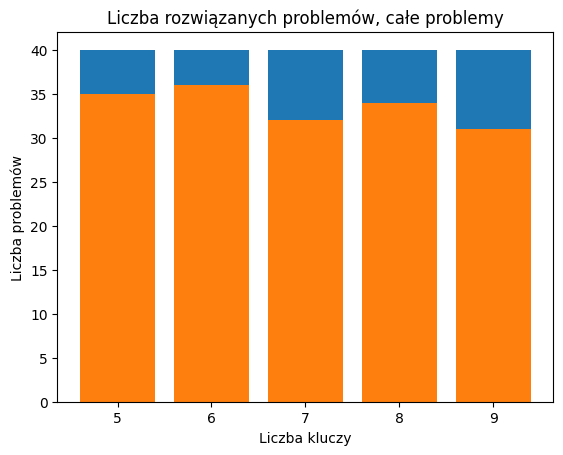

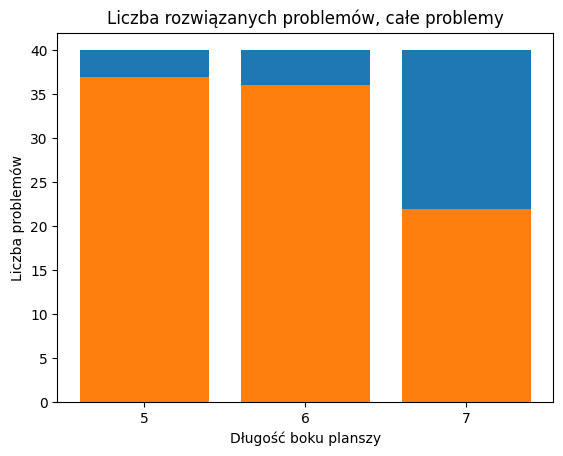

In [396]:
plt.xticks(x_ticks_size6)
plt.title("Liczba rozwiązanych problemów, całe problemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Liczba problemów')
plt.bar(df_means_size6_full_problems_all['keys_count'], df_means_size6_full_problems_all['time_out_count'])
plt.bar(df_means_size6_full_problems['keys_count'], df_means_size6_full_problems['time_out_count'])
plt.savefig('plots/solved_count_full_problems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Liczba rozwiązanych problemów, całe problemy")
plt.xlabel('Długość boku planszy')
plt.ylabel('Liczba problemów')
plt.bar(df_means_keys6_full_problems_all['size'], df_means_keys6_full_problems_all['time_out_count'])
plt.bar(df_means_keys6_full_problems['size'], df_means_keys6_full_problems['time_out_count'])
plt.savefig('plots/solved_count_size_full_problems.png')
plt.show()

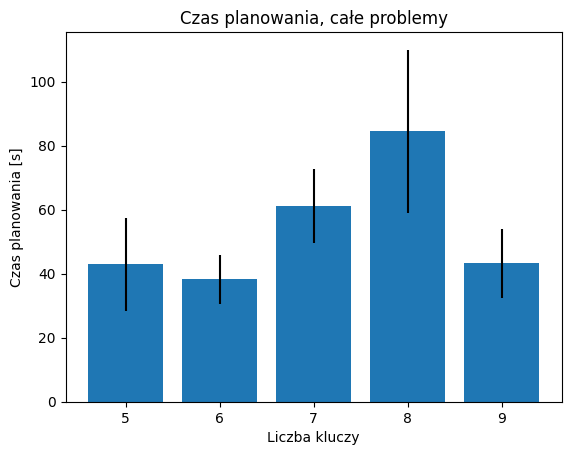

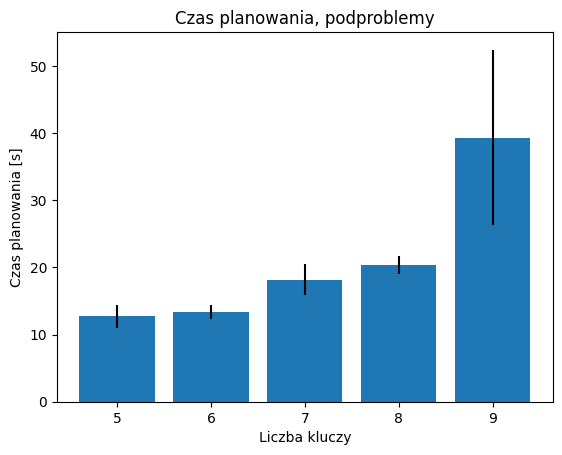

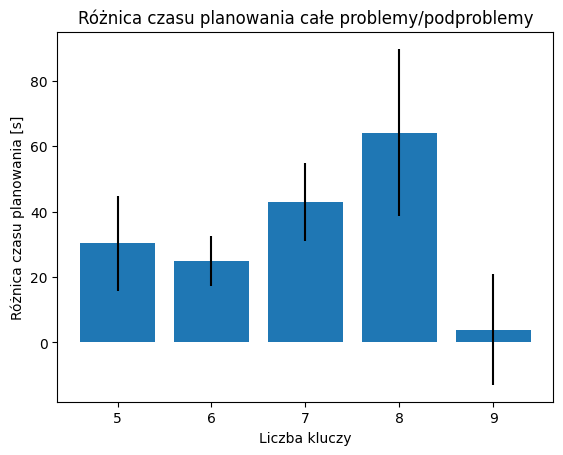

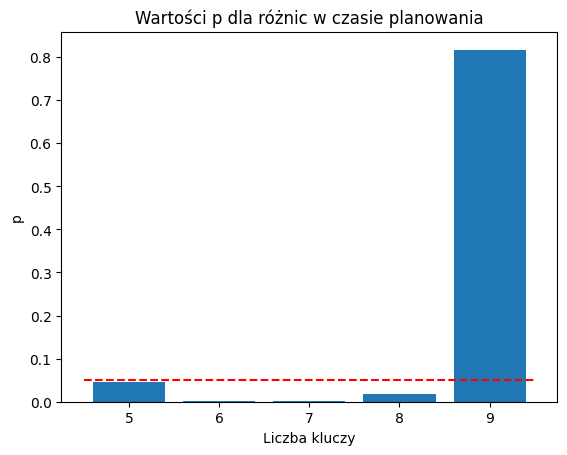

In [387]:
plt.xticks(x_ticks_size6)
plt.title("Czas planowania, całe problemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_size6_full_problems['keys_count'], df_means_size6_full_problems['planning_time'], yerr=df_means_size6_full_problems['std_avg'])
plt.savefig('plots/planning_time_full_problems.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Czas planowania, podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_size6_subproblems['keys_count'], df_means_size6_subproblems['planning_time'],
        yerr=df_means_size6_subproblems['std_avg'])
plt.savefig('plots/planning_time_subproblems.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Różnica czasu planowania całe problemy/podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Różnica czasu planowania [s]')
plt.bar(df_differences_selected['keys_count'], df_differences_selected['difference'],
        yerr=df_differences_selected['std'])
plt.savefig('plots/planning_time_differences.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Wartości p dla różnic w czasie planowania")
plt.xlabel('Liczba kluczy')
plt.ylabel('p')
plt.bar(different_times_pvalues_selected['keys_count'], different_times_pvalues_selected['p_value'])
plt.plot([min(different_times_pvalues_selected['keys_count']) - 0.5,
          max(different_times_pvalues_selected['keys_count']) + 0.5], [0.05, 0.05], 'r--')
plt.savefig('plots/planning_time_p_values.png')
plt.show()

In [388]:
different_times_pvalues_keys6_selected = different_times_pvalues[different_times_pvalues['keys_count'] == 6]
df_differences_keys6_selected = df_differences[df_differences['keys_count'] == 6]

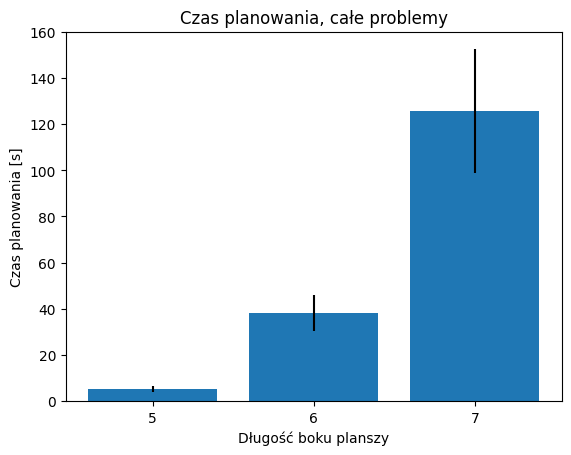

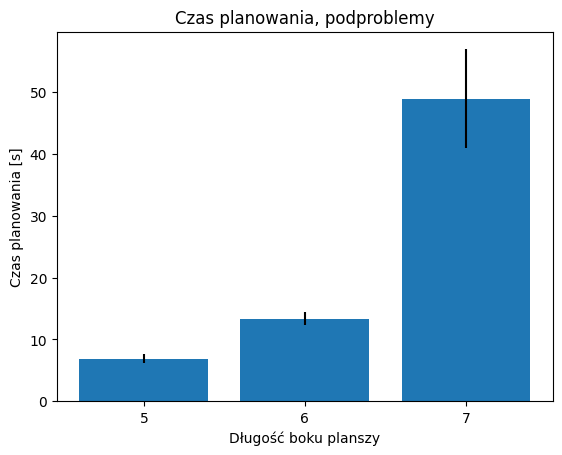

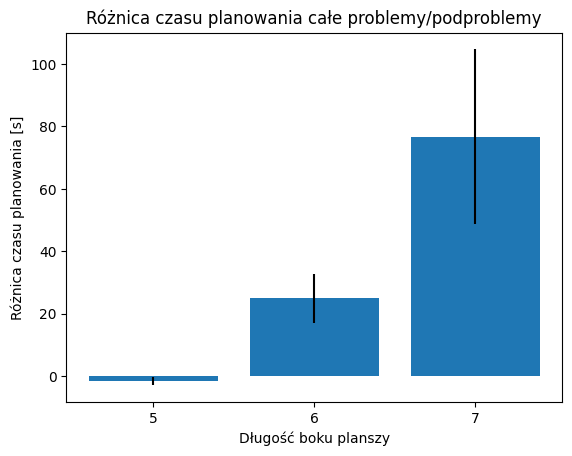

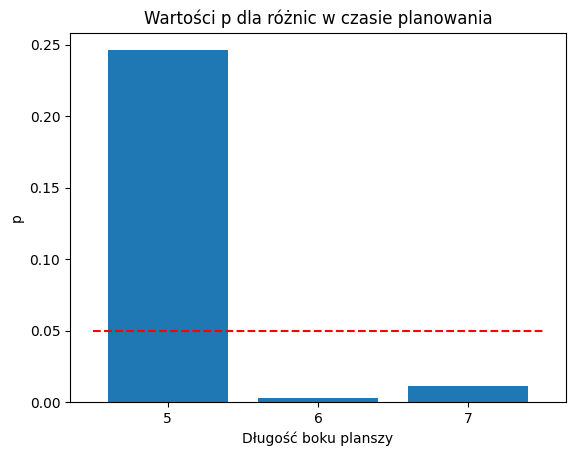

In [389]:
plt.xticks(x_ticks_keys6)
plt.title('Czas planowania, całe problemy')
plt.xlabel('Długość boku planszy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_keys6_full_problems['size'], df_means_keys6_full_problems['planning_time'], yerr=df_means_keys6_full_problems['std_avg'])
plt.savefig('plots/planning_time_size_full_problems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title('Czas planowania, podproblemy')
plt.xlabel('Długość boku planszy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_keys6_subproblems['size'], df_means_keys6_subproblems['planning_time'], yerr=df_means_keys6_subproblems['std_avg'])
plt.savefig('plots/planning_time_size_subproblems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title('Różnica czasu planowania całe problemy/podproblemy')
plt.xlabel('Długość boku planszy')
plt.ylabel('Różnica czasu planowania [s]')
plt.bar(df_differences_keys6_selected['size'], df_differences_keys6_selected['difference'], yerr=df_differences_keys6_selected['std'])
plt.savefig('plots/planning_time_size_differences.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Wartości p dla różnic w czasie planowania")
plt.xlabel('Długość boku planszy')
plt.ylabel('p')
plt.bar(different_times_pvalues_keys6_selected['size'], different_times_pvalues_keys6_selected['p_value'])
plt.plot([min(different_times_pvalues_keys6_selected['size']) - 0.5, max(different_times_pvalues_keys6_selected['size']) + 0.5], [0.05, 0.05], 'r--')
plt.savefig('plots/planning_time_size_p_values.png')
plt.show()

In [390]:
different_lengths_pvalues_filtered_size6_selected = different_lengths_pvalues_filtered[different_lengths_pvalues_filtered['size'] == 6]
df_differences_filtered_selected_size6 = df_differences_filtered[df_differences_filtered['size'] == 6]

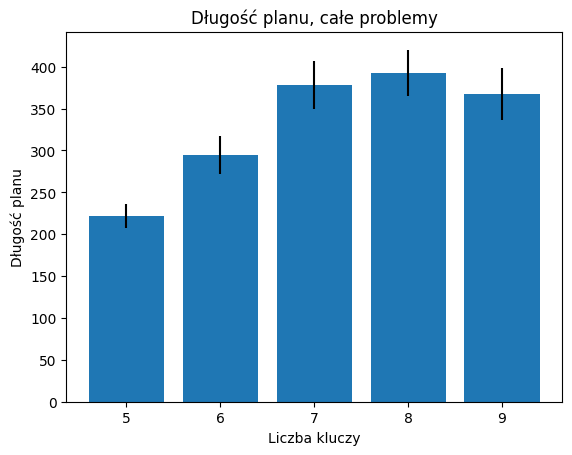

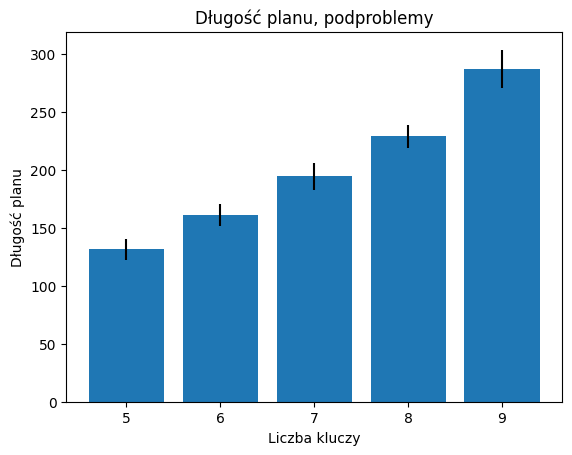

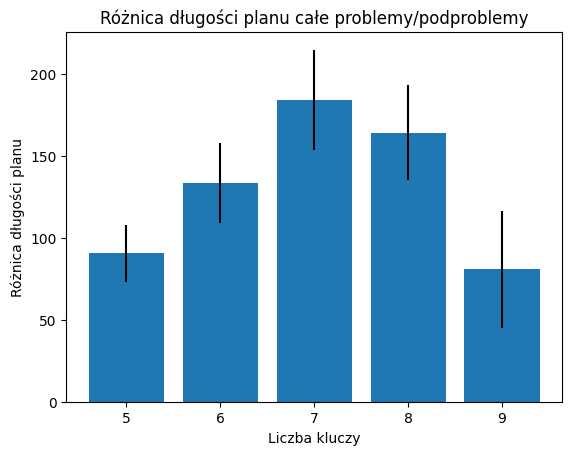

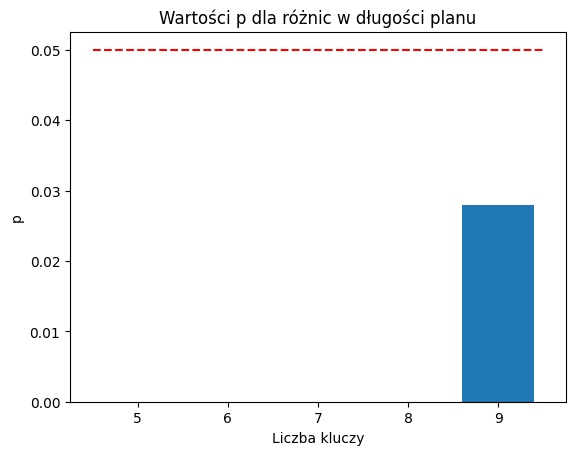

In [391]:
plt.xticks(x_ticks_size6)
plt.title("Długość planu, całe problemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Długość planu')
plt.bar(df_means_size6_full_problems_filtered['keys_count'], df_means_size6_full_problems_filtered['plan_length'], yerr=df_means_size6_full_problems_filtered['plan_length_std_avg'])
plt.savefig('plots/plan_length_full_problems.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Długość planu, podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Długość planu')
plt.bar(df_means_size6_subproblems_filtered['keys_count'], df_means_size6_subproblems_filtered['plan_length'], yerr=df_means_size6_subproblems_filtered['plan_length_std_avg'])
plt.savefig('plots/plan_length_subproblems.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Różnica długości planu całe problemy/podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Różnica długości planu')
plt.bar(df_differences_filtered_selected_size6['keys_count'], df_differences_filtered_selected_size6['difference'], yerr=df_differences_filtered_selected_size6['std'])
plt.savefig('plots/plan_length_differences.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Wartości p dla różnic w długości planu")
plt.xlabel('Liczba kluczy')
plt.ylabel('p')
plt.bar(different_lengths_pvalues_filtered_size6_selected['keys_count'], different_lengths_pvalues_filtered_size6_selected['p_value'])
plt.plot([min(different_lengths_pvalues_filtered_size6_selected['keys_count']) - 0.5, max(different_lengths_pvalues_filtered_size6_selected['keys_count']) + 0.5], [0.05, 0.05], 'r--')
plt.savefig('plots/plan_length_p_values.png')
plt.show()

In [392]:
p_values_filtered_selected = different_lengths_pvalues_filtered[different_lengths_pvalues_filtered['keys_count'] == 6]
df_differences_filtered_selected = df_differences_filtered[df_differences_filtered['keys_count'] == 6]

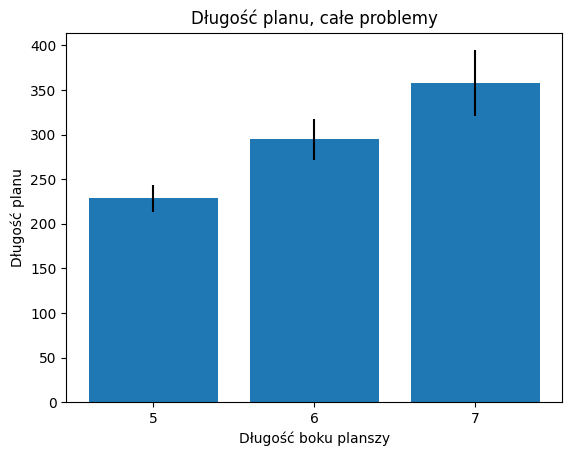

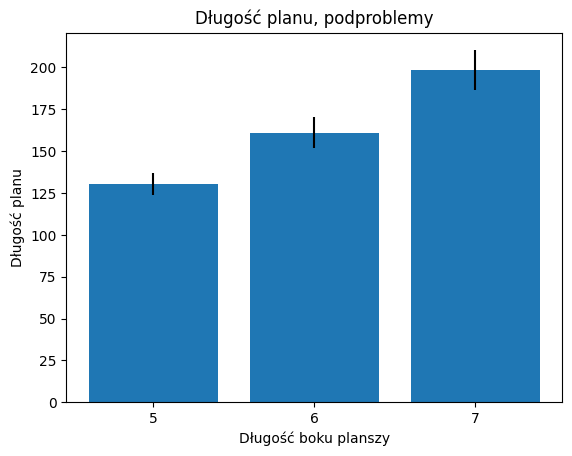

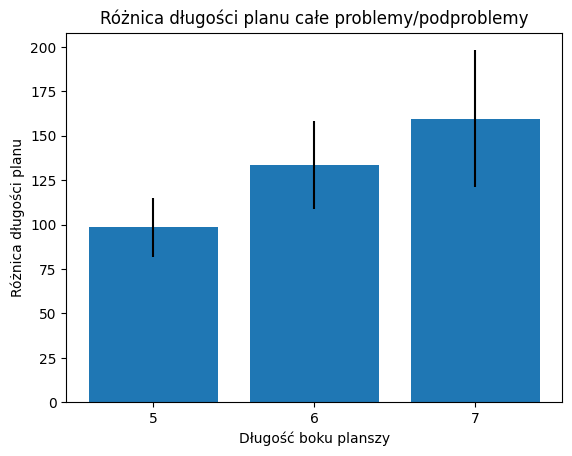

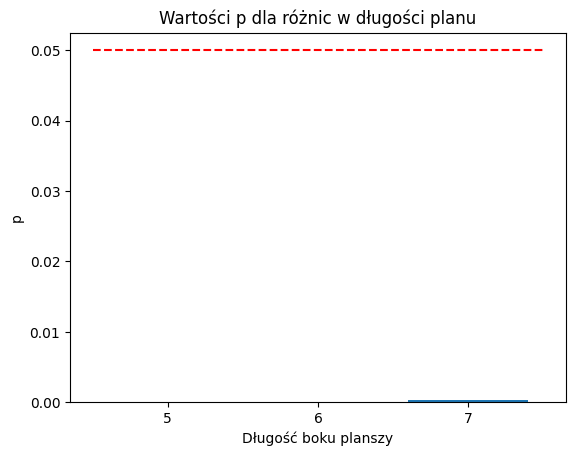

In [393]:
plt.xticks(x_ticks_keys6)
plt.title("Długość planu, całe problemy")
plt.xlabel('Długość boku planszy')
plt.ylabel('Długość planu')
plt.bar(df_means_keys6_full_problems_filtered['size'], df_means_keys6_full_problems_filtered['plan_length'], yerr=df_means_keys6_full_problems_filtered['plan_length_std_avg'])
plt.savefig('plots/plan_length_size_full_problems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Długość planu, podproblemy")
plt.xlabel('Długość boku planszy')
plt.ylabel('Długość planu')
plt.bar(df_means_keys6_subproblems_filtered['size'], df_means_keys6_subproblems_filtered['plan_length'], yerr=df_means_keys6_subproblems_filtered['plan_length_std_avg'])
plt.savefig('plots/plan_length_size_subproblems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Różnica długości planu całe problemy/podproblemy")
plt.xlabel('Długość boku planszy')
plt.ylabel('Różnica długości planu')
plt.bar(df_differences_filtered_selected['size'], df_differences_filtered_selected['difference'], yerr=df_differences_filtered_selected['std'])
plt.savefig('plots/plan_length_size_differences.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Wartości p dla różnic w długości planu")
plt.xlabel('Długość boku planszy')
plt.ylabel('p')
plt.bar(p_values_filtered_selected['size'], p_values_filtered_selected['p_value'])
plt.plot([min(p_values_filtered_selected['size']) - 0.5, max(p_values_filtered_selected['size']) + 0.5], [0.05, 0.05], 'r--')
plt.savefig('plots/plan_length_size_p_values.png')
plt.show()